# Implementation of the Model

In [1]:
# cuda check
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1


## Data1: Dodgers data set

#### Model implementation with torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class TimeSeriesUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TimeSeriesUNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 16)
        self.enc2 = conv_block(16, 32)
        self.enc3 = conv_block(32, 64)
        self.enc4 = conv_block(64, 128)
        self.enc5 = conv_block(128, 256)

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.up4 = up_block(256, 128)
        self.up3 = up_block(128, 64)
        self.up2 = up_block(64, 32)
        self.up1 = up_block(32, 16)

        self.reduce4 = nn.Conv1d(256, 128, kernel_size=1)
        self.reduce3 = nn.Conv1d(128, 64, kernel_size=1)
        self.reduce2 = nn.Conv1d(64, 32, kernel_size=1)
        self.reduce1 = nn.Conv1d(32, 16, kernel_size=1)

        self.final = nn.Conv1d(16, out_channels, kernel_size=1)

    def crop_and_concat(self, encoder_features, decoder_features):
        _, _, H_decoder = decoder_features.shape
        encoder_features = F.interpolate(encoder_features, size=H_decoder, mode="nearest")
        return torch.cat((encoder_features, decoder_features), dim=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        # print(enc1.shape)
        enc2 = self.enc2(self.pool(enc1))
        # print(enc2.shape)
        enc3 = self.enc3(self.pool(enc2))
        # print(enc3.shape)
        enc4 = self.enc4(self.pool(enc3))
        # print(enc4.shape)
        bottleneck = self.enc5(self.pool(enc4))
        # print(bottleneck.shape)

        up4 = self.up4(bottleneck)
        # print(up4.shape)
        up4 = self.crop_and_concat(enc4, up4)
        # print(up4.shape)
        up4 = self.reduce4(up4)
        # print(up4.shape)

        up3 = self.up3(up4)
        # print(up3.shape)
        up3 = self.crop_and_concat(enc3, up3)
        # print(up3.shape)
        up3 = self.reduce3(up3)
        # print(up3.shape)

        up2 = self.up2(up3)
        # print(up2.shape)
        up2 = self.crop_and_concat(enc2, up2)
        # print(up2.shape)
        up2 = self.reduce2(up2)
        # print(up2.shape)

        up1 = self.up1(up2)
        # print(up1.shape)
        up1 = self.crop_and_concat(enc1, up1)
        # print(up1.shape)
        up1 = self.reduce1(up1)
        # print(up1.shape)

        return torch.sigmoid(self.final(up1))

#### Import data set

In [4]:
import pandas as pd

In [5]:
data_1 = pd.read_csv(r'..\data\dodgers_data.csv')
data_1.head(1)

,timestamp,count,label
0,2005-04-10 00:00:00,0.0,0


In [6]:
data_1.set_index('timestamp', inplace=True)
data_1.head(1)

,count,label
timestamp,,
2005-04-10 00:00:00,0.0,0


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import MinMaxScaler

# # Normalize the `count` column
# scaler = MinMaxScaler()
# data_1["count"] = scaler.fit_transform(data_1["count"].values.reshape(-1, 1))
data_1["count"] = data_1["count"].astype(np.float32)

# Convert to supervised data
sequence_length = 1024  # Define how many time steps per sample
X, y = [], []
for i in range(len(data_1) - sequence_length):
    X.append(data_1["count"].iloc[i:i + sequence_length].values)
    y.append(data_1["label"].iloc[i + sequence_length - 1])  # Label corresponds to the last step
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Create pytorch data set

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets and DataLoaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
x, y = train_dataset[0]
print(x.shape, y.shape)

torch.Size([1, 1024]) torch.Size([1])


### Training

In [10]:
torch.cuda.is_available()

True

In [11]:
# Define model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesUNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for anomaly detection
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func_unet = []
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Ensure target tensor is float
        y_batch = y_batch.float()

        # Expand target size to match model output
        y_batch = y_batch.unsqueeze(-1).repeat(1, 1, X_batch.shape[-1])

        # Forward pass
        outputs = model(X_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_func_unet.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 0.2219
Epoch 2/10, Loss: 0.2100
Epoch 3/10, Loss: 0.2014
Epoch 4/10, Loss: 0.1967
Epoch 5/10, Loss: 0.1921
Epoch 6/10, Loss: 0.1871
Epoch 7/10, Loss: 0.1822
Epoch 8/10, Loss: 0.1789
Epoch 9/10, Loss: 0.1753
Epoch 10/10, Loss: 0.1728


#### Save the model

In [12]:
torch.save(model.state_dict(), 'timeseries_unet_model.pth')


# # Load the model and state dictionary
# # Define the model architecture
# model = TimeSeriesUNet(in_channels=1, out_channels=1)
# model.load_state_dict(torch.load('timeseries_unet_model.pth'))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# # Set the model to evaluation mode if you plan to evaluate or infer
# model.eval()


### Evaluate the model

In [13]:
test_loss = 0
criterion = torch.nn.BCELoss()  # Example loss function for binary classification

with torch.no_grad():
    for X, y in test_loader:  # Assuming single-input dataset
        X, y = X.to(device), y.to(device)

        # Forward pass
        outputs = model(X)

        # Align target shape with output shape
        y = y.unsqueeze(2)  # Add a dimension to make y [batch_size, 1, 1]
        y = y.expand_as(outputs)  # Expand y to match outputs shape [batch_size, 1, sequence_length]

        # Compute loss
        loss = criterion(outputs, y)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.1716


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
threshold = 0.3

# Flatten predictions and labels for metric calculation
predicted = (outputs > threshold).cpu().numpy().flatten()
true_labels = y.cpu().numpy().flatten()

# Compute metrics
accuracy = accuracy_score(true_labels, predicted)
precision = precision_score(true_labels, predicted)
recall = recall_score(true_labels, predicted)
f1 = f1_score(true_labels, predicted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8784
Precision: 0.6207


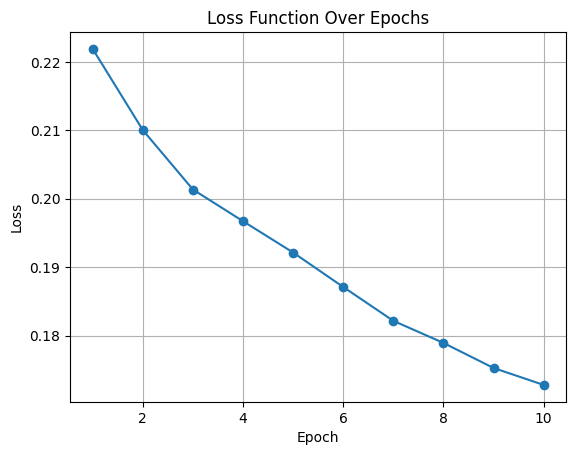

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(loss_func_unet) + 1), loss_func_unet, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function Over Epochs')
plt.grid(True)
plt.show()

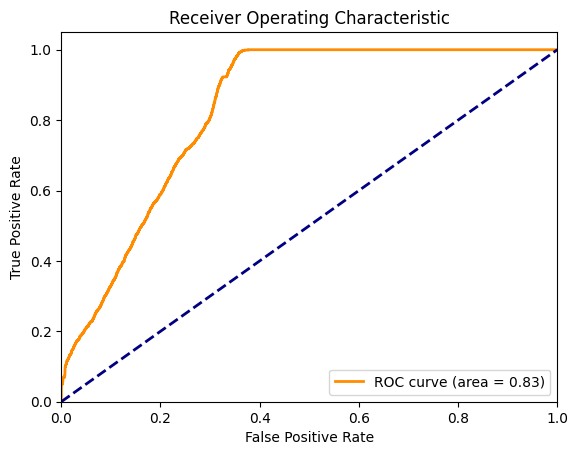

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels, outputs.cpu().numpy().flatten())
roc_auc = roc_auc_score(true_labels, outputs.cpu().numpy().flatten())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Data2: GHL

#### Model implementation with torch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedMUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimplifiedMUNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose1d(in_c, out_c, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 16)
        self.enc2 = conv_block(16, 32)
        self.enc3 = conv_block(32, 64)
        self.enc4 = conv_block(64, 128)

        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Bottleneck
        self.bottleneck = conv_block(128, 256)

        # Decoder
        self.up4 = up_block(256, 128)
        self.dec4 = conv_block(256, 128)
        self.up3 = up_block(128, 64)
        self.dec3 = conv_block(128, 64)
        self.up2 = up_block(64, 32)
        self.dec2 = conv_block(64, 32)
        self.up1 = up_block(32, 16)
        self.dec1 = conv_block(32, 16)

        # Final output layer
        self.final = nn.Conv1d(16, out_channels, kernel_size=1)

    def crop_and_concat(self, encoder_features, decoder_features):
        _, _, H_decoder = decoder_features.shape
        encoder_features = F.interpolate(encoder_features, size=H_decoder, mode="nearest")
        return torch.cat((encoder_features, decoder_features), dim=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(self.crop_and_concat(enc4, up4))

        up3 = self.up3(dec4)
        dec3 = self.dec3(self.crop_and_concat(enc3, up3))

        up2 = self.up2(dec3)
        dec2 = self.dec2(self.crop_and_concat(enc2, up2))

        up1 = self.up1(dec2)
        dec1 = self.dec1(self.crop_and_concat(enc1, up1))

        return torch.sigmoid(self.final(dec1))

### Import data set

In [4]:
import pandas as pd

In [5]:
data_2 = pd.read_csv('../data/ghl_data.csv')

In [6]:
data_2.head(1)

,Time,RT_level_ini,DANGER,RT_temperature.T,C_temperature.T,RT_level,dT_rand,limiter.y,dt_rand,C_level,...,HT_level,limiter1.y,dL_rand,out_valve_act_1.0,inv_valve_act_1.0,inj_valve_act_1.0,Relaxing.active_1.0,boundary.m_flow_in_20.0,dir_valve_act_1.0,heater_act_1.0
0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,0.0,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_2.set_index('Time', inplace=True)

data_2 = data_2.reset_index(drop=True)

data_2.head(1)

In [ ]:
import os
import pandas as pd

# Define the folder path
folder_path = '../data/GHL/'

# List all files in the folder that start with "preprocessed_" and end with ".csv"
file_list = [f for f in os.listdir(folder_path) if f.startswith('preprocessed_') and f.endswith('.csv')]

# Filter files to include only those with valid integer suffixes between 1 and 30
valid_files = []
for f in file_list:
    try:
        file_number = int(f.split('_')[1].split('.')[0])  # Extract the number
        if file_number in range(1, 31):  # Check if it's in the valid range
            valid_files.append(f)
    except ValueError:
        continue  # Skip files with non-integer suffixes

# Read and concatenate all CSV files
data_frames = [pd.read_csv(os.path.join(folder_path, file)) for file in valid_files]
data_ghl = pd.concat(data_frames, ignore_index=True)

In [10]:
# Display the first few rows of the concatenated DataFrame
data_ghl.head()

,Time,RT_level_ini,DANGER,FAULT,RT_temperature.T,C_temperature.T,RT_level,dT_rand,limiter.y,dt_rand,...,ATTACK,limiter1.y,dL_rand,out_valve_act_1.0,inv_valve_act_1.0,inj_valve_act_1.0,Relaxing.active_1.0,boundary.m_flow_in_20.0,dir_valve_act_1.0,heater_act_1.0
0,0.0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data_ghl.tail(3)

,Time,RT_level_ini,DANGER,FAULT,RT_temperature.T,C_temperature.T,RT_level,dT_rand,limiter.y,dt_rand,...,ATTACK,limiter1.y,dL_rand,out_valve_act_1.0,inv_valve_act_1.0,inj_valve_act_1.0,Relaxing.active_1.0,boundary.m_flow_in_20.0,dir_valve_act_1.0,heater_act_1.0
6139251,199999.0,0.604433,0.0,0.0,0.905107,1.0,0.287259,0.180535,0.0,0.426081,...,0.0,0.426081,0.180535,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6139252,200000.0,0.604433,0.0,0.0,0.905107,1.0,0.287259,0.180535,0.0,0.426081,...,0.0,0.426081,0.180535,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6139253,200000.0,0.604433,0.0,0.0,0.905107,1.0,0.287259,0.180535,0.0,0.426081,...,0.0,0.426081,0.180535,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# data_ghl.set_index('Time', inplace=True)
# data_ghl = data_ghl.reset_index(drop=True)
data_ghl.drop(columns=['Time'], inplace=True)
data_ghl.head(1)

,RT_level_ini,DANGER,FAULT,RT_temperature.T,C_temperature.T,RT_level,dT_rand,limiter.y,dt_rand,C_level,...,ATTACK,limiter1.y,dL_rand,out_valve_act_1.0,inv_valve_act_1.0,inj_valve_act_1.0,Relaxing.active_1.0,boundary.m_flow_in_20.0,dir_valve_act_1.0,heater_act_1.0
0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,0.0,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data preparation

In [14]:
features = data_ghl.drop(columns=['DANGER'])  # Exclude 'Time' and target column
target = data_ghl['DANGER']

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features.values, target.values, test_size=0.375, random_state=42, shuffle=False
)

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Training

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplifiedMUNet(in_channels=1, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        outputs = outputs.mean(dim=2)  # Ensure output shape matches target
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

### Evaluate the model

In [ ]:
model.eval()
test_loss = 0
with torch.no_grad():
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        outputs = model(x1, x2)
        loss = criterion(outputs, y)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Visualize a single prediction
x1, x2, y = next(iter(test_loader))
x1, x2, y = x1.to(device), x2.to(device), y.to(device)
outputs = model(x1, x2).cpu().detach().numpy()
y = y.cpu().numpy()

plt.plot(outputs[0, 0, :], label="Predicted")
plt.plot(y[0, 0, :], label="Ground Truth")
plt.legend()
plt.title("Predicted vs Ground Truth")
plt.show()


In [ ]:
model_path = 'simplified_munet_model.pth'
torch.save(model.state_dict(), model_path)

## Data3: EMG data set

### Import data set

In [32]:
data_3 = pd.read_csv(r'data\emg_data.csv')

In [33]:
data_3.head(1)

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,target
0,1,0.470588,0.436681,0.412844,0.437229,0.501961,0.464435,0.461864,0.431111,0


In [35]:
data_3.set_index('time', inplace=True)
data_3.head(1)

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,target
time,,,,,,,,,
1,0.470588,0.436681,0.412844,0.437229,0.501961,0.464435,0.461864,0.431111,0
